<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#1.-Récupération-des-données" data-toc-modified-id="1.-Récupération-des-données-1">1. Récupération des données</a></span></li><li><span><a href="#2.-Stabilité-des-données-dans-le-temps" data-toc-modified-id="2.-Stabilité-des-données-dans-le-temps-2">2. Stabilité des données dans le temps</a></span><ul class="toc-item"><li><span><a href="#2.1.-Evaluation-avec-le-score-de-silhouette" data-toc-modified-id="2.1.-Evaluation-avec-le-score-de-silhouette-2.1">2.1. Evaluation avec le score de silhouette</a></span></li><li><span><a href="#2.2.-Evaluation-avec-le-Adjusted-Rand-Index" data-toc-modified-id="2.2.-Evaluation-avec-le-Adjusted-Rand-Index-2.2">2.2. Evaluation avec le Adjusted Rand Index</a></span></li></ul></li></ul></div>

# Segmentez des clients d'un site e-commerce - Simulation

L'objectif de ce notebook est à partir du meilleur modèle sélectionné dans le notebook essais de déterminer la fréquence nécessaire de mise à jour du modèle de segmentation, afin que celui-ci reste pertinent.

Les essais ont été réalisés sur une période 8 mois. Je vais ici prédire pour chaque mois restant les clusters et évaluer la performance du modèle k-means avec le score de silhouette. On va vérifier si il y a une dégradation ou non de celui-ci dans le temps.

Je vais également entrainer le modèle sur la totalité des données pour récupérer tous les clusters. Je vais prédire à partir du modèle d'entrainement prédire les clusters sur chaque mois et calculer sur chaque prériode le Adjusted Rand Index pour évaluer la stabilté du modèle dans le temps.

In [1]:
import os

import matplotlib as mlp
import numpy as np
import pandas as pd
import seaborn as sns
import sys

from sklearn import cluster, metrics

from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.cluster import adjusted_rand_score

## 1. Récupération des données

In [2]:
path = "./data/cleaned/"
filename = "final_data.csv"

In [3]:
# create dataframe
data = pd.read_csv(path + filename)
data.head()

,last_order,mean_delivery_time,mean_price,mean_review_score,total_price,total_orders,delivered_ratio,recency
0,2018-05-10 11:11:18,2.001604,4.874434,5.0,4.874434,1,1.0,4.762174
1,2018-05-07 18:25:44,1.382288,2.990720,4.0,2.990720,1,1.0,4.779123
2,2017-03-10 21:05:03,3.285852,4.248495,3.0,4.248495,1,1.0,6.295266
3,2017-10-12 20:49:17,3.045640,3.295466,4.0,3.295466,1,1.0,5.786897
4,2017-11-14 20:06:52,2.648048,5.198497,5.0,5.198497,1,1.0,5.680173


Reprenons les dates maxi et mini de notre jeu de données.

In [4]:
data['last_order'].agg(['min', 'max'])

min    2016-09-15 12:16:38
max    2018-09-03 17:40:06
Name: last_order, dtype: object

Recréeons notre jeu de données d'entrainement.

In [5]:
start_date = '2017-02-01 00:00:00'
end_date = '2017-09-30 23:59:59'

mask = (data['last_order'] >= start_date) & (data['last_order'] <= end_date)
select_data = data.loc[mask]

In [6]:
# delete last_order date
X = select_data.drop(['last_order'], axis=1)

In [7]:
# scaling datas
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

## 2. Stabilité des données dans le temps

### 2.1. Evaluation avec le score de silhouette

In [8]:
# training model and calculate initial silhouette score
kmeans = cluster.KMeans(n_clusters=6, n_init=1, random_state=42)
kmeans.fit(X_scaled)
k_silh = metrics.silhouette_score(X_scaled, kmeans.labels_)
kmeans_statility_scores = {pd.to_datetime(end_date): k_silh}

In [9]:
for i in np.arange(0, 10):
    # create a dataframe and scaling it to predict the news clusters for a time lapse
    first_date = pd.to_datetime(end_date) + pd.Timedelta(days=30*i)
    last_date = pd.to_datetime(end_date) + pd.Timedelta(days=30*(i+1))
    mask = (pd.to_datetime(data['last_order']) > first_date) & (
        pd.to_datetime(data['last_order']) <= last_date)
    df = data.loc[mask]
    df = df.drop(['last_order'], axis=1)
    df_scaled = scaler.transform(df)

    # predict the new clusters
    mylabels = kmeans.predict(df_scaled)
    print("Date: {}, clusters {}".format(last_date, set(mylabels)))

    # calculate the silhouette score for the time lapse
    k_silh = metrics.silhouette_score(df_scaled, mylabels)
    kmeans_statility_scores.update({last_date: k_silh})

Date: 2017-10-30 23:59:59, clusters {1, 2, 3, 4, 5}
Date: 2017-11-29 23:59:59, clusters {1, 2, 3, 4, 5}
Date: 2017-12-29 23:59:59, clusters {1, 2, 3, 4, 5}
Date: 2018-01-28 23:59:59, clusters {1, 2, 3, 4, 5}
Date: 2018-02-27 23:59:59, clusters {1, 2, 3, 4, 5}
Date: 2018-03-29 23:59:59, clusters {1, 2, 3, 4, 5}
Date: 2018-04-28 23:59:59, clusters {1, 2, 3, 4, 5}
Date: 2018-05-28 23:59:59, clusters {1, 2, 3, 4, 5}
Date: 2018-06-27 23:59:59, clusters {1, 2, 3, 4, 5}
Date: 2018-07-27 23:59:59, clusters {1, 2, 3, 5}


In [10]:
# create a dataframe with all the silhouette scores by date
silhouettes_df = pd.DataFrame(kmeans_statility_scores.items(), columns=[
                              'Date', 'Score']).sort_values(by=['Date'])

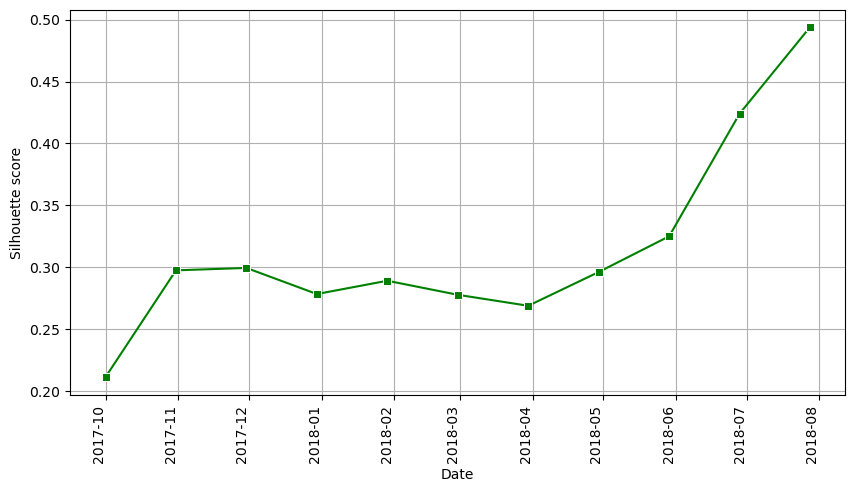

In [11]:
# plot the silhouette scores by date
plt.figure(figsize=(10, 5))
sns.lineplot(data=silhouettes_df, x='Date',
             y='Score', marker="s", color='green')
plt.xlabel("Date")
plt.xticks(rotation=90, ha='right')
plt.ylabel("Silhouette score")
plt.grid()
plt.show()

Le score de silhouette est constant jusqu'en juin 2018. Après cette date il augmente significativement. On peut expliquer cela de deux façons. La première est que le modèle est plus efficace pour déterminer les clusters. La seconde, plus probable, est que les nouvelles données font que l'on s'éloigne des résultats obtenus avec le modèle d'entrainement. Il faudrait donc réentrainer le modèle au bout de 8-9 mois pour segmenter au mieux les clients en tenant compte des nouveaux clients et des commandes supplémentaires.

Je vais vérifier cela grâce à l'Adjusted Rand Index.

### 2.2. Evaluation avec le Adjusted Rand Index

In [12]:
# create dataframe with all the datas minus the first monthes
start_date = '2017-02-01'
end_date = '2018-09-03'

mask = (data['last_order'] >= start_date) & (data['last_order'] <= end_date)
data_clustered = data.loc[mask]

In [13]:
# dropping dates and scaling datas
X_clustered = data_clustered.drop(['last_order'], axis=1)
X_clustered_scaled = scaler.fit_transform(X_clustered)

In [14]:
# fit the model on the scaled datas and determine the clusters
kmeans = cluster.KMeans(n_clusters=6, n_init=1, random_state=42)
kmeans.fit(X_clustered_scaled)
data_clustered['true_labels'] = kmeans.labels_

C:\Users\ludov\AppData\Local\Temp\ipykernel_5552\1410834952.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_clustered['true_labels'] = kmeans.labels_


In [15]:
data_clustered.head()

,last_order,mean_delivery_time,mean_price,mean_review_score,total_price,total_orders,delivered_ratio,recency,true_labels
0,2018-05-10 11:11:18,2.001604,4.874434,5.0,4.874434,1,1.0,4.762174,5
1,2018-05-07 18:25:44,1.382288,2.990720,4.0,2.990720,1,1.0,4.779123,2
2,2017-03-10 21:05:03,3.285852,4.248495,3.0,4.248495,1,1.0,6.295266,3
3,2017-10-12 20:49:17,3.045640,3.295466,4.0,3.295466,1,1.0,5.786897,2
4,2017-11-14 20:06:52,2.648048,5.198497,5.0,5.198497,1,1.0,5.680173,5


In [16]:
# training the model on the 8 first monthes
kmeans_fit = cluster.KMeans(n_clusters=6, n_init=1, random_state=42)
kmeans_fit.fit(X_scaled)

KMeans(n_clusters=6, n_init=1, random_state=42)

In [17]:
end_date = '2017-09-30 23:59:59'
ARI = {}
for i in range(0, 10):
    # create a dataframe and scaling it to predict the news clusters for a time lapse
    first_date = pd.to_datetime(end_date) + pd.Timedelta(days=30*i)
    last_date = pd.to_datetime(end_date) + pd.Timedelta(days=30*(i+1))
    mask = (pd.to_datetime(data['last_order']) > first_date) & (
        pd.to_datetime(data['last_order']) <= last_date)
    df = data.loc[mask]
    df = df.drop(['last_order'], axis=1)
    df_scaled = scaler.fit_transform(df)

    # get true_labels on the same time lapse
    df_clustered = data_clustered.loc[mask]

    # predict clusters
    df_clustered['predict_labels'] = kmeans_fit.predict(df_scaled)

    # calculate ARI for the time lapse
    ari_score = adjusted_rand_score(
        df_clustered['true_labels'], df_clustered['predict_labels'])
    ARI.update({last_date: ari_score})

C:\Users\ludov\AppData\Local\Temp\ipykernel_5552\3199714283.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustered['predict_labels'] = kmeans_fit.predict(df_scaled)
C:\Users\ludov\AppData\Local\Temp\ipykernel_5552\3199714283.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clustered['predict_labels'] = kmeans_fit.predict(df_scaled)
C:\Users\ludov\AppData\Local\Temp\ipykernel_5552\3199714283.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
T

In [18]:
# create a dataframe with all the ARI scores by date
ari_df = pd.DataFrame(ARI.items(), columns=[
                      'Date', 'ARI']).sort_values(by=['Date'])

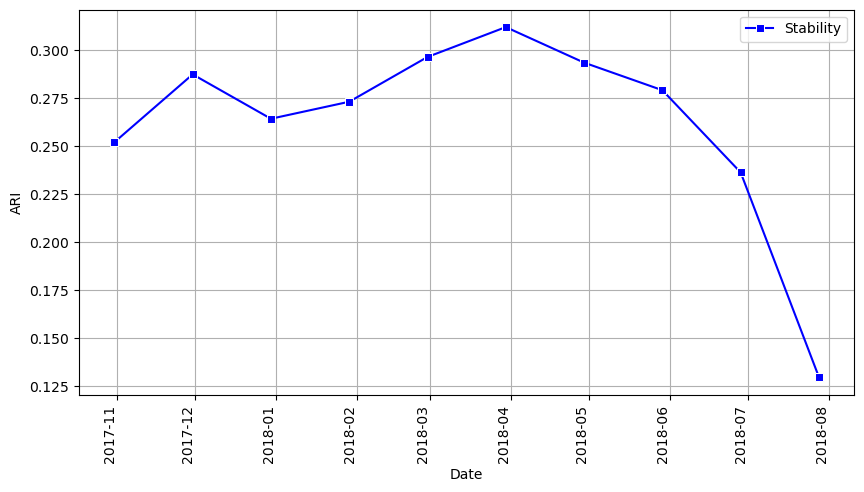

In [19]:
# plot ARI scores by date
plt.figure(figsize=(10, 5))
sns.lineplot(data=ari_df, x='Date', y='ARI', marker="s",
             color='blue', label='Stability')
plt.xlabel("Date")
plt.xticks(rotation=90, ha='right')
plt.ylabel("ARI")
plt.grid()
plt.show()

L'ARI est constant jusqu'à juin 2018. Après cette date il s'effondre.
On retrouve le même laps de temps qu'avec le score de silhouette.

Pour la maintenance on peut prévoir une période de 8 mois au delà de laquelle il est préférable d'entrainer à nouveau le modèle avec les nouvelles données obtenues.